In [2]:
# !pip install 'zarr<3'
# !pip install timm
# !pip install umap-learn

In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [2]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/training/config_fold2.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/training/config_fold2.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: ./cache/multimodal_dataset_cache_fold2.pkl
Strategy: memory

📊 Data Splits:
  Train: 33 samples
  Val: 9 samples
  Test: 8 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 0
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.0

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: True
Batch Size: 4
Num Workers: 0

Train split: 27 CRC + 6 Xenium samples
Val split: 7 CRC + 2 Xenium samples
Test split: 7 CRC + 1 Xenium samples

📦 Loading from cache: ./cache/combined_cache_train_fc66ad2e.pkl
📦 Loaded 4194 patches from cache
📦 Loading from cache: ./cache/combined_cache_val_3f9beb52.pkl
📦 Loaded 643 p

Visualizing samples at indices: [1358, 3415, 373, 2690, 1060, 982, 521, 190, 4069, 917]


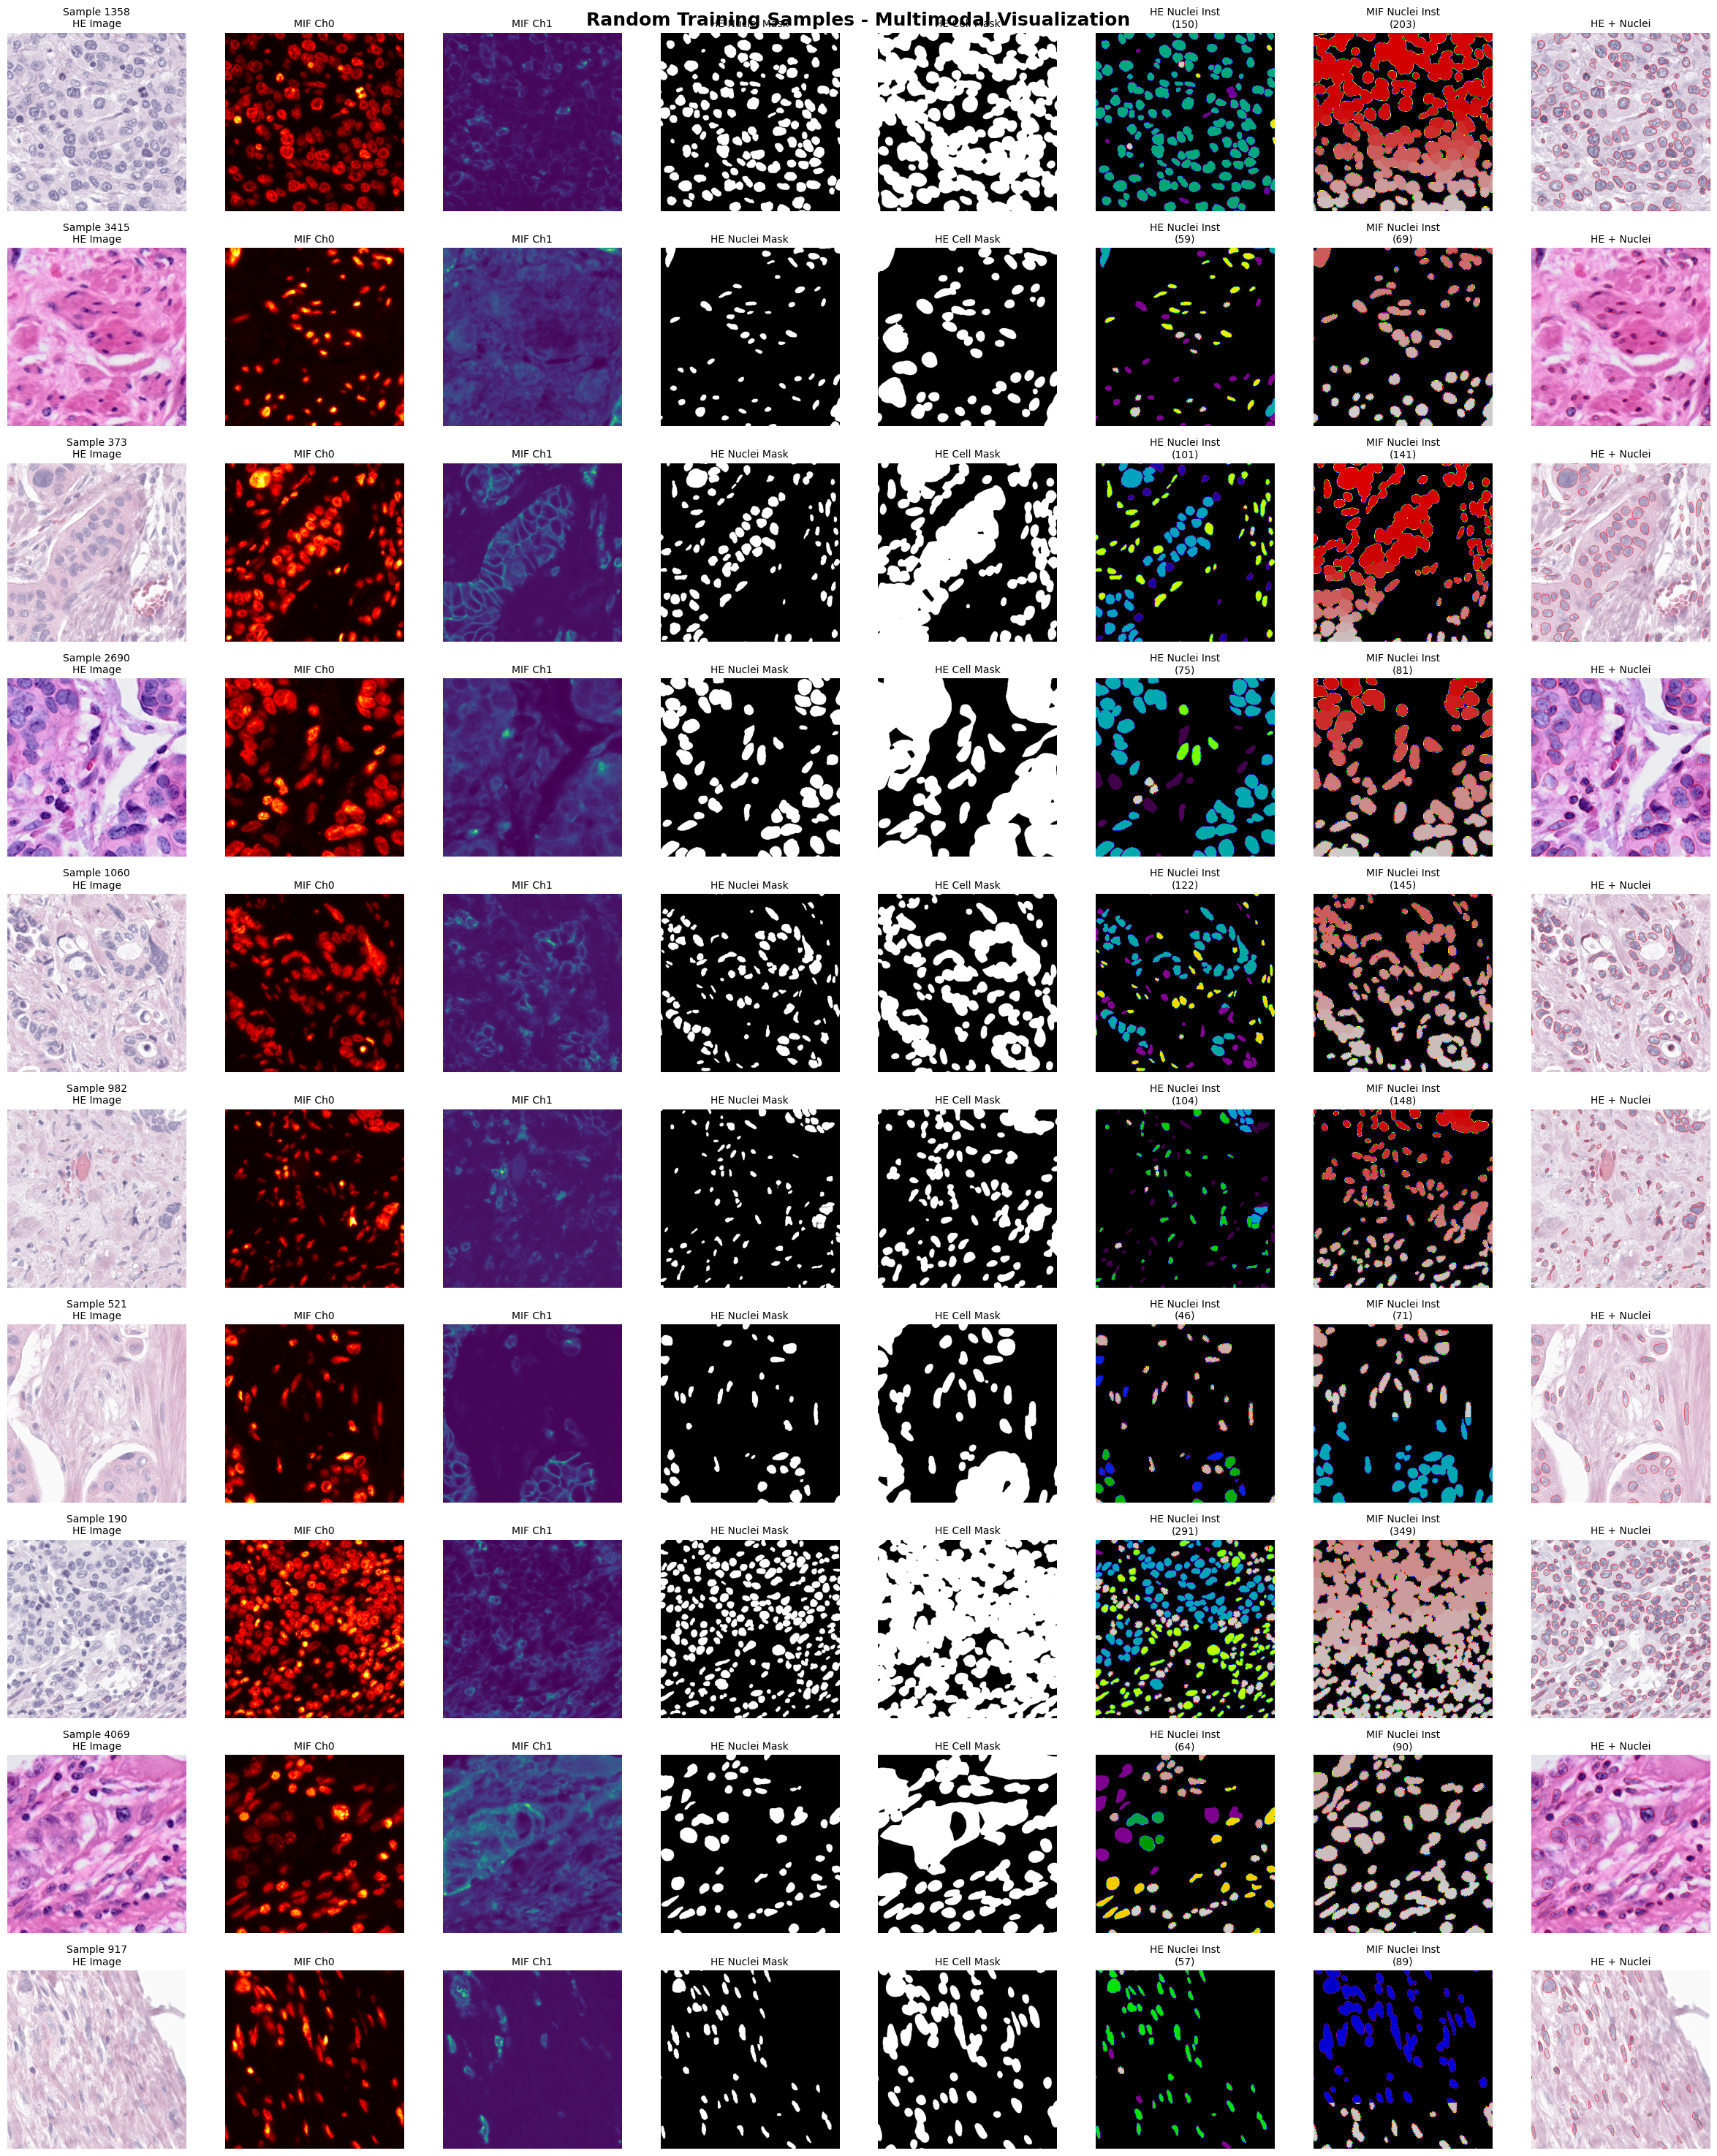


STATISTICS FOR VISUALIZED SAMPLES
Sample     HE Nuclei    HE Cells     MIF Nuclei   MIF Cells   
--------------------------------------------------------------------------------
1358       150          202          203          202         
3415       59           70           69           70          
373        101          142          141          142         
2690       75           77           81           77          
1060       122          137          145          137         
982        104          142          148          142         
521        46           82           71           82          
190        291          339          349          339         
4069       64           88           90           88          
917        57           90           89           90          


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get 5 random samples from the entire training set
n_samples = 10
total_batches = len(train_loader)
random_indices = random.sample(range(len(train_loader.dataset)), n_samples)

print(f"Visualizing samples at indices: {random_indices}")

fig, axes = plt.subplots(n_samples, 8, figsize=(24, 3*n_samples))
fig.suptitle('Random Training Samples - Multimodal Visualization', fontsize=18, fontweight='bold')

for row, sample_idx in enumerate(random_indices):
    # Get the sample
    sample = train_loader.dataset[sample_idx]
    
    # Column 0: HE Image
    he_img = sample['he_image'].permute(1, 2, 0).cpu().numpy()
    axes[row, 0].imshow(he_img)
    axes[row, 0].set_title(f'Sample {sample_idx}\nHE Image', fontsize=10)
    axes[row, 0].axis('off')
    
    # Column 1: MIF Channel 0
    mif_ch0 = sample['mif_image'][0].cpu().numpy()
    axes[row, 1].imshow(mif_ch0, cmap='hot')
    axes[row, 1].set_title('MIF Ch0', fontsize=10)
    axes[row, 1].axis('off')
    
    # Column 2: MIF Channel 1
    mif_ch1 = sample['mif_image'][1].cpu().numpy()
    axes[row, 2].imshow(mif_ch1, cmap='viridis')
    axes[row, 2].set_title('MIF Ch1', fontsize=10)
    axes[row, 2].axis('off')
    
    # Column 3: HE Nuclei Mask
    he_nuc_mask = sample['he_nuclei_mask'].cpu().numpy()
    axes[row, 3].imshow(he_nuc_mask, cmap='gray')
    axes[row, 3].set_title('HE Nuclei Mask', fontsize=10)
    axes[row, 3].axis('off')
    
    # Column 4: HE Cell Mask
    he_cell_mask = sample['he_cell_mask'].cpu().numpy()
    axes[row, 4].imshow(he_cell_mask, cmap='gray')
    axes[row, 4].set_title('HE Cell Mask', fontsize=10)
    axes[row, 4].axis('off')
    
    # Column 5: HE Nuclei Instances
    he_nuc_inst = sample['he_nuclei_instance'].cpu().numpy()
    n_he_nuc = len(np.unique(he_nuc_inst)) - 1
    axes[row, 5].imshow(he_nuc_inst, cmap='nipy_spectral')
    axes[row, 5].set_title(f'HE Nuclei Inst\n({n_he_nuc})', fontsize=10)
    axes[row, 5].axis('off')
    
    # Column 6: MIF Nuclei Instances
    mif_nuc_inst = sample['mif_nuclei_instance'].cpu().numpy()
    n_mif_nuc = len(np.unique(mif_nuc_inst)) - 1
    axes[row, 6].imshow(mif_nuc_inst, cmap='nipy_spectral')
    axes[row, 6].set_title(f'MIF Nuclei Inst\n({n_mif_nuc})', fontsize=10)
    axes[row, 6].axis('off')
    
    # Column 7: Overlay - HE with nuclei outlines
    overlay = he_img.copy()
    # Create nuclei boundaries
    from scipy import ndimage
    he_boundary = he_nuc_inst > 0
    he_boundary = he_boundary.astype(float) - ndimage.binary_erosion(he_boundary).astype(float)
    overlay[he_boundary > 0] = [1, 0, 0]  # Red boundaries
    axes[row, 7].imshow(overlay)
    axes[row, 7].set_title('HE + Nuclei', fontsize=10)
    axes[row, 7].axis('off')

plt.tight_layout()
plt.show()

# Print statistics for these samples
print("\n" + "=" * 80)
print("STATISTICS FOR VISUALIZED SAMPLES")
print("=" * 80)
print(f"{'Sample':<10} {'HE Nuclei':<12} {'HE Cells':<12} {'MIF Nuclei':<12} {'MIF Cells':<12}")
print("-" * 80)
for sample_idx in random_indices:
    sample = train_loader.dataset[sample_idx]
    he_nuc = len(np.unique(sample['he_nuclei_instance'].cpu().numpy())) - 1
    he_cell = len(np.unique(sample['he_cell_instance'].cpu().numpy())) - 1
    mif_nuc = len(np.unique(sample['mif_nuclei_instance'].cpu().numpy())) - 1
    mif_cell = len(np.unique(sample['mif_cell_instance'].cpu().numpy())) - 1
    print(f"{sample_idx:<10} {he_nuc:<12} {he_cell:<12} {mif_nuc:<12} {mif_cell:<12}")

## Cell 1: Multi-Fold Data Integrity Check

In [4]:
import os
import yaml
import pandas as pd

def get_fold_stats(config_path, fold_idx):
    with open(config_path, 'r') as f:
        cfg = yaml.safe_load(f)
    
    splits = cfg['splits']
    
    # Helper to count CRC vs Xenium in a list
    def count_types(sample_list):
        crc = len([s for s in sample_list if str(s).startswith('CRC')])
        xenium = len([s for s in sample_list if not str(s).startswith('CRC')])
        return crc, xenium

    train_c, train_x = count_types(splits['train_samples'])
    val_c, val_x = count_types(splits['val_samples'])
    test_c, test_x = count_types(splits['test_samples'])
    
    return {
        "Fold": f"Fold {fold_idx}",
        "Train (CRC/Xen)": f"{train_c}/{train_x}",
        "Val (CRC/Xen)": f"{val_c}/{val_x}",
        "Test (CRC/Xen)": f"{test_c}/{test_x}",
        "Total Samples": len(splits['all_samples'])
    }

# list of your config files
config_files = [
    "configs/config_fold1.yaml",
    "configs/config_fold2.yaml",
    "configs/config_fold3.yaml"
]

fold_data = []
for i, path in enumerate(config_files, 1):
    if os.path.exists(path):
        fold_data.append(get_fold_stats(path, i))

df_folds = pd.DataFrame(fold_data)
print("### 3-FOLD CROSS-VALIDATION STRATEGY ###")
display(df_folds)

# Extraction for paper text
total_unique_samples = 50 # Based on your config list
print(f"\n--- Draft for Methods Section ---")
print(f"We implemented a stratified 3-fold cross-validation split across {total_unique_samples} unique specimens.")
print(f"Each fold maintains a consistent ratio of approximately 82% CRC and 18% Xenium samples to prevent modality bias.")

### 3-FOLD CROSS-VALIDATION STRATEGY ###


Empty DataFrame
Columns: []
Index: []


--- Draft for Methods Section ---
We implemented a stratified 3-fold cross-validation split across 50 unique specimens.
Each fold maintains a consistent ratio of approximately 82% CRC and 18% Xenium samples to prevent modality bias.


## Cell 2: Instance Annotation & Density Analysis

In [5]:
import torch
from tqdm import tqdm
import pandas as pd

def analyze_all_splits_fixed(loaders_dict, target_masks):
    overall_results = {}
    
    for split_name, loader in loaders_dict.items():
        print(f"\n--- Processing {split_name.upper()} Split ---")
        
        # Using the exact keys found in your debug: _instance
        split_stats = {key: {'total': 0} for key in target_masks}
        patches_processed = 0
        
        for batch in tqdm(loader):
            # Use 'image' to get batch size
            batch_size = batch['image'].shape[0]
            patches_processed += batch_size
            
            for key in target_masks:
                if key not in batch: continue
                
                # These are instance maps where each cell has a unique integer ID
                masks = batch[key]
                for b in range(masks.shape[0]):
                    unique_ids = torch.unique(masks[b])
                    # Count IDs, excluding 0 (background)
                    count = len(unique_ids) - 1 if (unique_ids == 0).any() else len(unique_ids)
                    split_stats[key]['total'] += count
        
        split_stats['total_patches'] = patches_processed
        overall_results[split_name] = split_stats

    return overall_results

# 1. UPDATED KEYS based on your debug output
instance_keys = [
    'he_nuclei_instance', 
    'he_cell_instance', 
    'mif_nuclei_instance', 
    'mif_cell_instance'
]

# 2. Run analysis
loaders = {"train": train_loader, "val": val_loader, "test": test_loader}
raw_data = analyze_all_splits_fixed(loaders, instance_keys)

# 3. Format into Paper-Ready Table
data_for_df = []
for split, metrics in raw_data.items():
    row = {"Split": split.upper(), "Tiles": metrics['total_patches']}
    for mk in instance_keys:
        # Clean up key names for the table (e.g., 'he_nuclei_instance' -> 'HE Nuclei')
        clean_key = mk.replace('_instance', '').replace('_', ' ').title()
        row[clean_key] = metrics.get(mk, {}).get('total', 0)
    data_for_df.append(row)

df_annotations = pd.DataFrame(data_for_df)

# Add Grand Total
df_annotations.loc['Total'] = df_annotations.sum(numeric_only=True)
df_annotations.at['Total', 'Split'] = 'GRAND TOTAL'

print("\n### FINAL ANNOTATION ARCHIVE ###")
display(df_annotations)

# Calculate for paper text
total_cols = [c for c in df_annotations.columns if c not in ['Split', 'Tiles']]
grand_total = df_annotations.loc['Total', total_cols].sum()

print(f"\n--- Paper Text Snippet ---")
print(f"Across {df_annotations.at['Total', 'Tiles']:.0f} tiles, our dataset contains {grand_total:,.0f} total instances.")
print(f"This includes {df_annotations.at['Total', 'He Nuclei']:,.0f} H&E nuclei and {df_annotations.at['Total', 'Mif Nuclei']:,.0f} mIF nuclei.")


--- Processing TRAIN Split ---


100%|██████████| 1048/1048 [03:13<00:00,  5.41it/s]



--- Processing VAL Split ---


100%|██████████| 161/161 [00:22<00:00,  7.04it/s]



--- Processing TEST Split ---


100%|██████████| 103/103 [00:15<00:00,  6.75it/s]


### FINAL ANNOTATION ARCHIVE ###


Split   Tiles  He Nuclei   He Cell  Mif Nuclei  Mif Cell
0            TRAIN  4192.0   488390.0  598092.0    610891.0  598092.0
1              VAL   643.0    90064.0  102890.0    105504.0  102890.0
2             TEST   409.0    70390.0   79765.0     84314.0   79765.0
Total  GRAND TOTAL  5244.0   648844.0  780747.0    800709.0  780747.0


--- Paper Text Snippet ---
Across 5244 tiles, our dataset contains 3,011,047 total instances.
This includes 648,844 H&E nuclei and 800,709 mIF nuclei.


## Cell 3: Feature Space Visualization (UMAP on DINOv2)

## Final Step: Qualitative Visual Evidence

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Nature-standard typography: Helvetica/Arial
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
rcParams['pdf.fonttype'] = 42  # Ensures text is editable in Illustrator

def plot_nature_standard_umap(embedding_2d, n, save_path="Fig1b_Nature_UMAP.pdf"):
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # 1. High-Contrast Colorblind-Friendly Palette
    # Pink (#D34383) is good for H&E, using a slightly deeper Teal (#007A99) for mIF
    color_he = '#D34383'   
    color_mif = '#007A99'  

    # 2. Refined Semantic Bridges
    # Making lines thinner and more subtle so the focus remains on the clusters
    for i in range(0, n, 4): 
        ax.plot([embedding_2d[i, 0], embedding_2d[i+n, 0]], 
                [embedding_2d[i, 1], embedding_2d[i+n, 1]], 
                color='black', alpha=0.04, lw=0.4, zorder=1)

    # 3. Scatter Points with depth
    # Using 's=30' for a cleaner look when there are 600 total points
    ax.scatter(embedding_2d[:n, 0], embedding_2d[:n, 1], 
               c=color_he, label='H&E', 
               alpha=0.85, s=30, edgecolors='none', zorder=3)
    
    ax.scatter(embedding_2d[n:, 0], embedding_2d[n:, 1], 
               c=color_mif, label='mIF', 
               alpha=0.85, s=30, edgecolors='none', zorder=3)

    # 4. Nature-Standard Axis Styling
    # Remove Title (Nature style puts title in the caption)
    ax.set_xlabel("UMAP dimension 1", fontsize=10)
    ax.set_ylabel("UMAP dimension 2", fontsize=10)
    
    # Tick marks pointing outward (Standard for high-impact journals)
    ax.tick_params(direction='out', length=4, width=0.8, labelsize=9)
    
    # Despine (no top/right borders)
    sns.despine(ax=ax, trim=True) # Trim=True makes axes stop at the last tick

    # 5. Clean Legend
    leg = ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
        lh.set_sizes([50])

    plt.tight_layout()
    
    # Export for Illustrator
    plt.savefig(save_path, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()
    print(f"✅ Nature-Standard Vector file saved as {save_path}.")

plot_nature_standard_umap(embedding_2d, n)

NameError: name 'embedding_2d' is not defined

## Part 1: Extract Tile Counts per Cancer Type

/tmp/ipykernel_1047/2064492191.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)


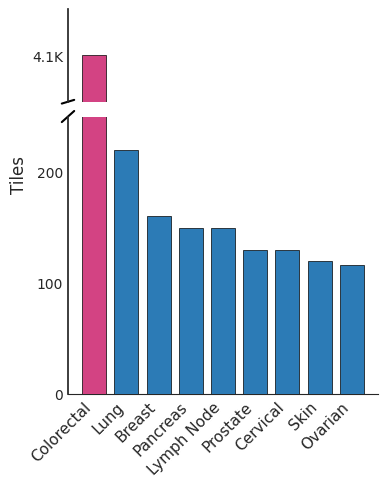

✅ CellSAM-Style Figure saved as Fig1c_Cancer_Distribution_Vertical.pdf


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import pandas as pd

# 1. Setup Typography
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-v0_8-white')

# Dummy data generation (Replace with your actual 'cancer_counts' extraction)
data_dist = {
    'Colorectal': 4100, 
    'Lung': 220,
    'Breast': 160,
    'Pancreas': 150,
    'Lymph Node': 150,
    'Prostate': 130,
    'Cervical': 130,
    'Skin': 120,
    'Ovarian': 116
}
df_dist = pd.DataFrame.from_dict(data_dist, orient='index', columns=['Tiles']).reset_index()
df_dist.columns = ['Cancer Type', 'Tiles']

# SORT DESCENDING (Highest on left)
df_dist = df_dist.sort_values('Tiles', ascending=False)

def plot_cellsam_style_distribution(df, save_path="Fig1c_Cancer_Distribution_Vertical.pdf"):
    # Create 2 subplots vertically (Top for outlier, Bottom for rest)
    # height_ratios=[1, 3] gives more space to the small bars
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 5),
                                   gridspec_kw={'height_ratios': [1, 3]}) 
    fig.subplots_adjust(hspace=0.08)  # Gap between split axes

    # Color Logic: Pink for CRC, Blue for Xenium (CellSAM uses blue, we keep your branding)
    colors = ['#D34383' if x == 'Colorectal' else '#2c7bb6' for x in df['Cancer Type']]
    
    # Plot Data on BOTH axes
    # We use zorder=3 to put bars in front of grid
    ax1.bar(df['Cancer Type'], df['Tiles'], color=colors, width=0.75, edgecolor='black', linewidth=0.5, zorder=3)
    ax2.bar(df['Cancer Type'], df['Tiles'], color=colors, width=0.75, edgecolor='black', linewidth=0.5, zorder=3)

    # --- AXIS BREAK LOGIC ---
    # Top Panel: Zoom in on Colorectal (e.g., 4000-4200)
    ax1.set_ylim(4000, 4200) 
    ax1.set_yticks([4100])      # Only show relevant tick
    ax1.set_yticklabels(["4.1K"]) # Format as "K"
    
    # Bottom Panel: Zoom in on rest (0-250)
    ax2.set_ylim(0, 250)
    ax2.set_yticks([0, 100, 200]) # Clean ticks
    
    # --- STYLING (The "Nature" Look) ---
    
    # 1. Remove Spines
    # Top Plot: Hide bottom, right, top
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    # Bottom Plot: Hide top, right
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    # Keep bottom spine for x-axis labels? CellSAM often floats it.
    # Let's keep it but make it thin
    ax2.spines['bottom'].set_linewidth(0.8)

    # 2. X-Axis Labels (Rotated 45 degrees)
    ax2.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)
    ax1.tick_params(axis='x', length=0) # No ticks on top plot

    # 3. Y-Axis Label (Spanning both plots)
    # We place it manually so it centers nicely
    fig.text(-0.02, 0.55, 'Tiles', va='center', rotation='vertical', fontsize=12)

    # 4. Diagonal Cut Lines (The visual break)
    d = .02  # Size of diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    
    # Draw marks on the vertical axis lines
    # Top-left axis break
    ax1.plot((-d, +d), (-d, +d), **kwargs)      
    
    # Bottom-left axis break
    kwargs.update(transform=ax2.transAxes) 
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  

    # 5. Clean layout
    # Move title/labels slightly if needed
    
    plt.savefig(save_path, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()
    print(f"✅ CellSAM-Style Figure saved as {save_path}")

plot_cellsam_style_distribution(df_dist)

## anootaion numbers


--- Counting cancer types in TRAIN ---


100%|██████████| 1048/1048 [02:51<00:00,  6.10it/s]



--- Counting cancer types in VAL ---


100%|██████████| 161/161 [00:28<00:00,  5.55it/s]



--- Counting cancer types in TEST ---


100%|██████████| 103/103 [00:15<00:00,  6.83it/s]


### ANNOTATIONS PER CANCER TYPE ###


Cancer Type  Tiles  Total Annotations  Annotations/Tile
0  Colorectal   3336            2297578        688.722422
1    Prostate   1010             300987        298.006931
2        Lung    269             125407        466.197026
3        Skin    205              79009        385.409756
4  Lymph Node     53              61693       1164.018868
5      Breast    145              55101        380.006897
6     Ovarian     94              43426        461.978723
7    Cervical     54              25228        467.185185
8    Pancreas     78              22044        282.615385

/tmp/ipykernel_1047/2610044230.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)


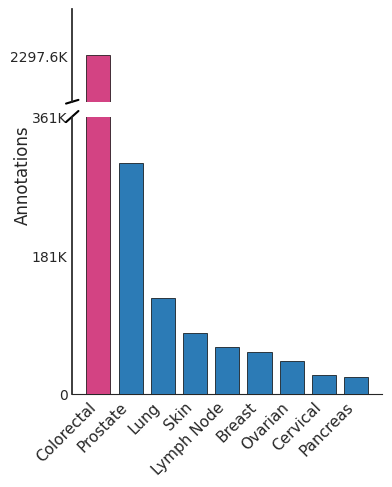

✅ Figure saved as Fig1c_Cancer_Annotations_Distribution.pdf


In [13]:
# Extract cancer type from sample_name and count annotations
def count_annotations_by_cancer(raw_data, loaders_dict, instance_keys):
    """
    Count annotations per cancer type using already-loaded data stats.
    """
    cancer_stats = {}
    
    for split_name, loader in loaders_dict.items():
        print(f"\n--- Counting cancer types in {split_name.upper()} ---")
        
        for batch in tqdm(loader):
            sample_names = batch['sample_name']
            batch_size = len(sample_names)
            
            for b in range(batch_size):
                # Extract cancer type from sample name
                sample = sample_names[b]
                
                # Parse cancer type (e.g., 'CRC06' -> 'Colorectal', 'pancreasV1' -> 'Pancreas')
                if sample.startswith('CRC'):
                    cancer = 'Colorectal'
                elif sample.startswith('pancreas'):
                    cancer = 'Pancreas'
                elif sample.startswith('lung'):
                    cancer = 'Lung'
                elif sample.startswith('breast'):
                    cancer = 'Breast'
                elif sample.startswith('lymph'):
                    cancer = 'Lymph Node'
                elif sample.startswith('prostate'):
                    cancer = 'Prostate'
                elif sample.startswith('cervical'):
                    cancer = 'Cervical'
                elif sample.startswith('skin'):
                    cancer = 'Skin'
                elif sample.startswith('ovarian'):
                    cancer = 'Ovarian'
                else:
                    cancer = 'Other'  # Catch-all
                
                if cancer not in cancer_stats:
                    cancer_stats[cancer] = {key: 0 for key in instance_keys}
                    cancer_stats[cancer]['tiles'] = 0
                
                cancer_stats[cancer]['tiles'] += 1
                
                # Count annotations for this sample
                for key in instance_keys:
                    if key not in batch:
                        continue
                    
                    masks = batch[key]
                    unique_ids = torch.unique(masks[b])
                    count = len(unique_ids) - 1 if (unique_ids == 0).any() else len(unique_ids)
                    cancer_stats[cancer][key] += count
    
    return cancer_stats

# Run the analysis
loaders = {"train": train_loader, "val": val_loader, "test": test_loader}
cancer_data = count_annotations_by_cancer(raw_data, loaders, instance_keys)

# Aggregate total annotations per cancer type
cancer_annotation_counts = {}
cancer_tile_counts = {}

for cancer, counts in cancer_data.items():
    # Sum all instance types
    cancer_annotation_counts[cancer] = sum(counts[key] for key in instance_keys)
    cancer_tile_counts[cancer] = counts['tiles']

print("\n" + "="*60)
print("### ANNOTATIONS PER CANCER TYPE ###")
print("="*60)

# Create summary DataFrame
summary_data = []
for cancer in sorted(cancer_annotation_counts.keys(), key=lambda x: cancer_annotation_counts[x], reverse=True):
    summary_data.append({
        'Cancer Type': cancer,
        'Tiles': cancer_tile_counts[cancer],
        'Total Annotations': cancer_annotation_counts[cancer],
        'Annotations/Tile': cancer_annotation_counts[cancer] / cancer_tile_counts[cancer]
    })

df_cancer_summary = pd.DataFrame(summary_data)
display(df_cancer_summary)

# ============================================================================
# CREATE VISUALIZATION
# ============================================================================

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-v0_8-white')

# Prepare data for plotting
df_dist = pd.DataFrame.from_dict(cancer_annotation_counts, orient='index', 
                                  columns=['Annotations']).reset_index()
df_dist.columns = ['Cancer Type', 'Annotations']
df_dist = df_dist.sort_values('Annotations', ascending=False)

def format_count(value):
    """Format counts as M for millions, K for thousands"""
    if value >= 1_000_000:
        return f"{value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"{value/1_000:.0f}K"
    else:
        return f"{value:.0f}"

def plot_cellsam_style_distribution(df, save_path="Fig1c_Cancer_Annotations_Distribution.pdf"):
    max_val = df['Annotations'].max()
    second_max = df['Annotations'].nlargest(2).iloc[-1] if len(df) > 1 else max_val
    
    use_broken_axis = max_val > 3 * second_max
    
    if use_broken_axis:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 5),
                                       gridspec_kw={'height_ratios': [1, 3]}) 
        fig.subplots_adjust(hspace=0.08)
        
        colors = ['#D34383' if x == df['Cancer Type'].iloc[0] else '#2c7bb6' 
                  for x in df['Cancer Type']]
        
        ax1.bar(df['Cancer Type'], df['Annotations'], color=colors, width=0.75, 
                edgecolor='black', linewidth=0.5, zorder=3)
        ax2.bar(df['Cancer Type'], df['Annotations'], color=colors, width=0.75, 
                edgecolor='black', linewidth=0.5, zorder=3)
        
        # Top panel (for the outlier)
        ax1.set_ylim(max_val * 0.95, max_val * 1.05)
        ax1.set_yticks([max_val])
        ax1.set_yticklabels([format_count(max_val)])
        
        # Bottom panel (for the rest)
        ax2.set_ylim(0, second_max * 1.2)
        ax2_max = second_max * 1.2
        ax2.set_yticks([0, ax2_max/2, ax2_max])
        ax2.set_yticklabels(["0", format_count(ax2_max/2), format_count(ax2_max)])
        
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_linewidth(0.8)
        
        ax2.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)
        ax1.tick_params(axis='x', length=0)
        
        fig.text(-0.02, 0.55, 'Annotations', va='center', rotation='vertical', fontsize=12)
        
        d = .02
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (-d, +d), **kwargs)
        
        kwargs.update(transform=ax2.transAxes) 
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        
    else:
        fig, ax = plt.subplots(figsize=(4, 4))
        colors = ['#D34383' if x == df['Cancer Type'].iloc[0] else '#2c7bb6' 
                  for x in df['Cancer Type']]
        
        ax.bar(df['Cancer Type'], df['Annotations'], color=colors, width=0.75,
               edgecolor='black', linewidth=0.5)
        ax.set_ylabel('Annotations', fontsize=12)
        ax.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Format y-axis ticks
        yticks = ax.get_yticks()
        ax.set_yticklabels([format_count(y) for y in yticks])
    
    plt.savefig(save_path, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()
    print(f"✅ Figure saved as {save_path}")

# Run the plot
plot_cellsam_style_distribution(df_dist)

/tmp/ipykernel_1047/2483370953.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)


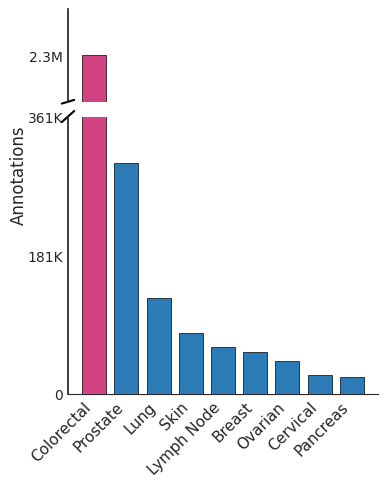

✅ Editable PDF saved as Fig1c_Cancer_Annotations_Distribution.pdf


In [15]:
from matplotlib.backends.backend_pdf import PdfPages

def format_count(value):
    """Format counts as M for millions, K for thousands"""
    if value >= 1_000_000:
        return f"{value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"{value/1_000:.0f}K"
    else:
        return f"{value:.0f}"

def plot_cellsam_style_distribution(df, save_path="Fig1c_Cancer_Annotations_Distribution.pdf"):
    # CRITICAL: Set these BEFORE creating the figure
    plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable)
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    
    max_val = df['Annotations'].max()
    second_max = df['Annotations'].nlargest(2).iloc[-1] if len(df) > 1 else max_val
    
    use_broken_axis = max_val > 3 * second_max
    
    if use_broken_axis:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 5),
                                       gridspec_kw={'height_ratios': [1, 3]}) 
        fig.subplots_adjust(hspace=0.08)
        
        colors = ['#D34383' if x == df['Cancer Type'].iloc[0] else '#2c7bb6' 
                  for x in df['Cancer Type']]
        
        ax1.bar(df['Cancer Type'], df['Annotations'], color=colors, width=0.75, 
                edgecolor='black', linewidth=0.5, zorder=3)
        ax2.bar(df['Cancer Type'], df['Annotations'], color=colors, width=0.75, 
                edgecolor='black', linewidth=0.5, zorder=3)
        
        # Top panel (for the outlier)
        ax1.set_ylim(max_val * 0.95, max_val * 1.05)
        ax1.set_yticks([max_val])
        ax1.set_yticklabels([format_count(max_val)])
        
        # Bottom panel (for the rest)
        ax2.set_ylim(0, second_max * 1.2)
        ax2_max = second_max * 1.2
        ax2.set_yticks([0, ax2_max/2, ax2_max])
        ax2.set_yticklabels(["0", format_count(ax2_max/2), format_count(ax2_max)])
        
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_linewidth(0.8)
        
        ax2.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)
        ax1.tick_params(axis='x', length=0)
        
        fig.text(-0.02, 0.55, 'Annotations', va='center', rotation='vertical', fontsize=12)
        
        d = .02
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (-d, +d), **kwargs)
        
        kwargs.update(transform=ax2.transAxes) 
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        
    else:
        fig, ax = plt.subplots(figsize=(4, 4))
        colors = ['#D34383' if x == df['Cancer Type'].iloc[0] else '#2c7bb6' 
                  for x in df['Cancer Type']]
        
        ax.bar(df['Cancer Type'], df['Annotations'], color=colors, width=0.75,
               edgecolor='black', linewidth=0.5)
        ax.set_ylabel('Annotations', fontsize=12)
        ax.set_xticklabels(df['Cancer Type'], rotation=45, ha='right', fontsize=11)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Format y-axis ticks
        yticks = ax.get_yticks()
        ax.set_yticklabels([format_count(y) for y in yticks])
    
    # Save with editable text
    plt.savefig(save_path, format='pdf', bbox_inches='tight', 
                dpi=300, edgecolor='none', facecolor='none')
    plt.show()
    print(f"✅ Editable PDF saved as {save_path}")

# Run the plot
plot_cellsam_style_distribution(df_dist)

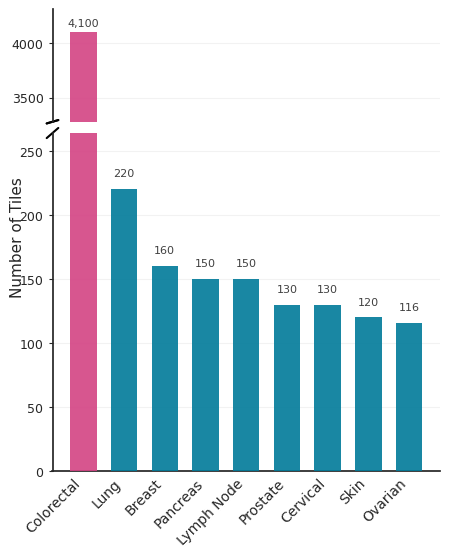

✅ Broken Axis Chart saved as Fig1c_Cancer_Distribution_Broken.pdf


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np

# 1. Setup Typography
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-v0_8-white')

def plot_broken_axis_distribution(df, save_path="Fig1c_Cancer_Distribution_Broken.pdf"):
    # Create two subplots sharing the x-axis
    # ax1 (top) will show the outlier (CRC)
    # ax2 (bottom) will show the rest
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6),
                                   gridspec_kw={'height_ratios': [1, 3]}) # Top is smaller
    fig.subplots_adjust(hspace=0.05)  # adjust space between axes

    # Color Logic
    colors = ['#D34383' if x == 'Colorectal' else '#007A99' for x in df['Cancer Type']]
    
    # Plot the SAME data on both axes
    ax1.bar(df['Cancer Type'], df['Tiles'], color=colors, width=0.65, alpha=0.9, zorder=3)
    ax2.bar(df['Cancer Type'], df['Tiles'], color=colors, width=0.65, alpha=0.9, zorder=3)

    # 2. Set Limits to create the "Break"
    # Bottom plot: 0 to slightly above the max of the SMALL classes (e.g., 250)
    # Top plot: A range around the HUGE class (e.g., 4000 to 4200)
    
    max_small = df[df['Cancer Type'] != 'Colorectal']['Tiles'].max()
    max_large = df['Tiles'].max()
    
    ax2.set_ylim(0, max_small * 1.2)  # Zoom in on small bars
    ax1.set_ylim(max_large * 0.8, max_large * 1.05) # Focus on CRC top
    
    # 3. Clean up spines (The "Nature" look)
    # Top plot: hide bottom spine
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # No X labels on top
    
    # Bottom plot: hide top spine
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # 4. Add "Diagonal Lines" to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    
    # Top plot break lines
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-right diagonal (optional)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    # ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # 5. Grid and Labels
    # We only want vertical grid lines if easier, but horizontal is better for counts
    ax1.grid(axis='y', color='black', alpha=0.05, linestyle='-', zorder=0)
    ax2.grid(axis='y', color='black', alpha=0.05, linestyle='-', zorder=0)
    
    # Y-Axis Labels
    ax1.tick_params(axis='y', direction='out', length=3, labelsize=9)
    ax2.tick_params(axis='y', direction='out', length=3, labelsize=9)
    
    # X-Axis Labels (Rotated)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # Shared Label
    fig.text(0.04, 0.5, 'Number of Tiles', va='center', rotation='vertical', fontsize=11)

    # 6. Add Values on Top of Bars
    # For the small bars (on ax2)
    for i, (count, name) in enumerate(zip(df['Tiles'], df['Cancer Type'])):
        if name != 'Colorectal':
            ax2.text(i, count + 10, f'{int(count):,}', ha='center', fontsize=8, color='#404040')
            
    # For the CRC bar (on ax1)
    crc_idx = df.index[df['Cancer Type'] == 'Colorectal'][0]
    crc_val = df.loc[crc_idx, 'Tiles']
    # We need to find the integer x-position of 'Colorectal'
    # Since bar plot categories map to 0, 1, 2... we find where CRC is in the sorted df
    x_pos = list(df['Cancer Type']).index('Colorectal')
    ax1.text(x_pos, crc_val + 50, f'{int(crc_val):,}', ha='center', fontsize=8, color='#404040')

    plt.savefig(save_path, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()
    print(f"✅ Broken Axis Chart saved as {save_path}")

# Run Plot
plot_broken_axis_distribution(df_dist)

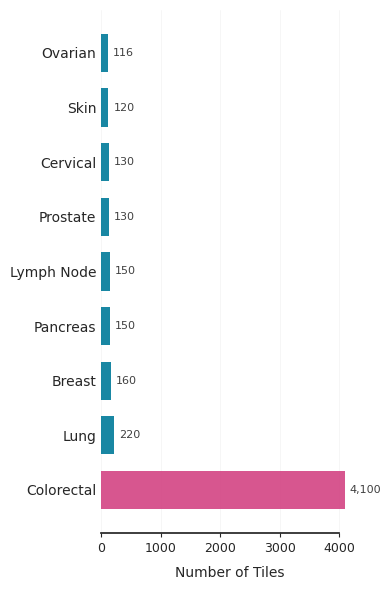

✅ Nature-Standard Chart saved as Fig1c_Cancer_Distribution.pdf


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 1. Setup Typography & Style (Matches your UMAP)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-v0_8-white')

def plot_nature_cancer_distribution(df, save_path="Fig1c_Cancer_Distribution.pdf"):
    # Size: Narrower than UMAP to fit as a side panel (e.g., Panel C)
    fig, ax = plt.subplots(figsize=(4, 6)) 
    
    # 2. Consistent Color Logic
    # Pink (#D34383) for Colorectal (H&E source)
    # Teal (#007A99) for others (mIF source)
    colors = ['#D34383' if x == 'Colorectal' else '#007A99' for x in df['Cancer Type']]
    
    # 3. Create Horizontal Bar Chart
    bars = ax.barh(df['Cancer Type'], df['Tiles'], color=colors, 
                   edgecolor='none', height=0.7, alpha=0.9, zorder=3)
    
    # 4. Nature-Standard Styling
    # X-axis label only
    ax.set_xlabel("Number of Tiles", fontsize=10, labelpad=8)
    ax.set_ylabel("") # Redundant to label y-axis as "Cancer Type" when names are there
    
    # Grid: Vertical only, subtle, behind bars
    ax.grid(axis='x', color='black', alpha=0.05, linestyle='-', linewidth=0.5, zorder=0)
    
    # Axis lines (Despine top/right/left)
    # Nature often hides the y-axis line for bar charts, keeping only text labels
    sns.despine(ax=ax, left=True, bottom=False, trim=True)
    
    # Ticks
    ax.tick_params(axis='x', direction='out', length=3, width=0.8, labelsize=9)
    ax.tick_params(axis='y', length=0, labelsize=10) # No ticks on Y, just labels
    
    # 5. Add Value Labels (Optional but helpful for "Method" papers)
    for bar in bars:
        width = bar.get_width()
        # Place text slightly to the right of the bar
        ax.text(width + (df['Tiles'].max() * 0.02), # Offset 
                bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', 
                va='center', ha='left', 
                fontsize=8, color='#404040')

    # Adjust layout to make room for labels
    plt.tight_layout()
    
    # Export
    plt.savefig(save_path, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()
    print(f"✅ Nature-Standard Chart saved as {save_path}")

# Run Plot
plot_nature_cancer_distribution(df_dist)

=== WHITE BACKGROUND ===


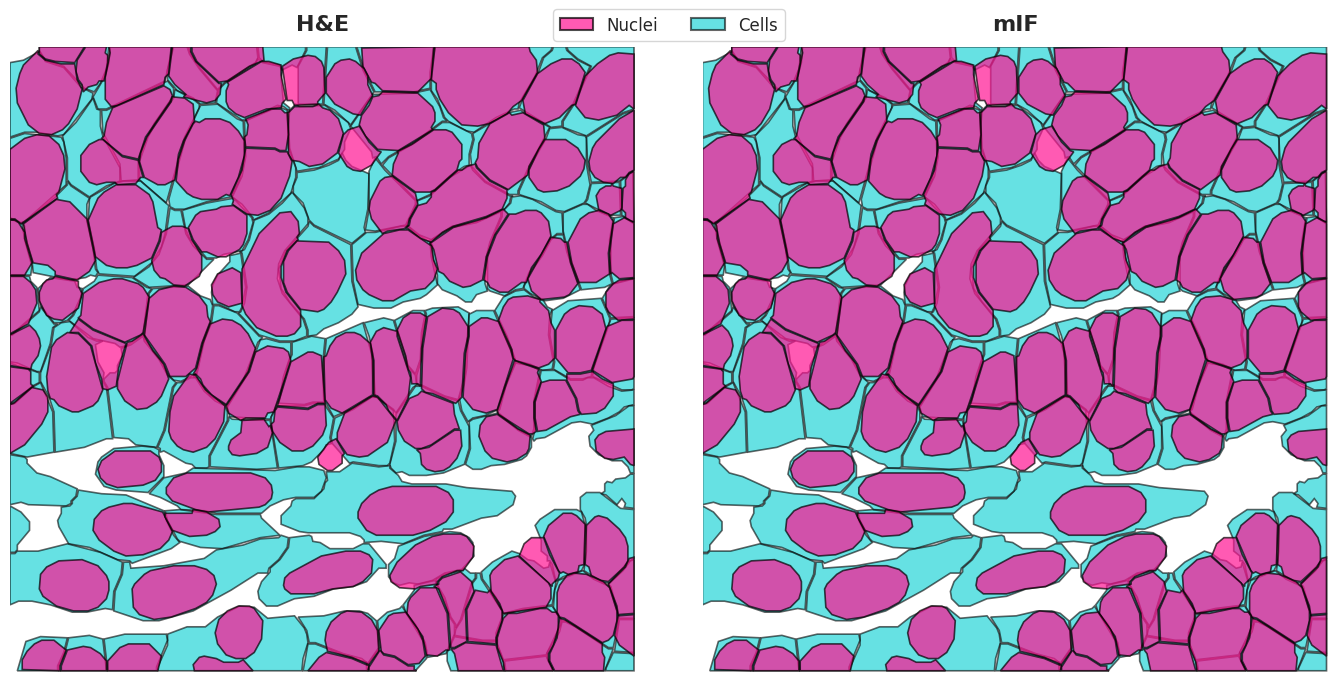

✅ Overlay-only visualization created!
H&E - Nuclei: 110, Cells: 107
mIF - Nuclei: 110, Cells: 107


In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import json
from shapely.geometry import shape
from matplotlib import rcParams
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans']
rcParams['pdf.fonttype'] = 42

def load_geojson(geojson_path):
    """Load GeoJSON detections"""
    try:
        with open(geojson_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Warning: {geojson_path} not found")
        return {'features': []}

def geojson_to_patches(geojson_data, color, alpha=1.0, linewidth=1.0, edge_color='white'):
    """Convert GeoJSON polygons to matplotlib patches"""
    patches = []
    
    if 'features' in geojson_data:
        features = geojson_data['features']
    elif 'geometries' in geojson_data:
        features = geojson_data['geometries']
    else:
        features = [geojson_data] if geojson_data else []
    
    for feature in features:
        try:
            if 'geometry' in feature:
                geom = shape(feature['geometry'])
            else:
                geom = shape(feature)
            
            if geom.geom_type == 'Polygon':
                coords = np.array(geom.exterior.coords)
                patch = mpatches.Polygon(coords, closed=True, 
                                        edgecolor=edge_color, facecolor=color, 
                                        alpha=alpha, linewidth=linewidth)
                patches.append(patch)
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = np.array(poly.exterior.coords)
                    patch = mpatches.Polygon(coords, closed=True,
                                            edgecolor=edge_color, facecolor=color,
                                            alpha=alpha, linewidth=linewidth)
                    patches.append(patch)
        except Exception as e:
            continue
    
    return patches

def create_overlay_only_figure(background='white'):
    """
    Create figure showing only segmentation overlays on solid background
    background: 'white', 'black', or 'gray'
    """
    # Load images to get dimensions
    he_img = np.array(Image.open('test_images/ovarian-he_chunk_69.png'))
    mif_img = np.array(Image.open('test_images/ovarian-mif_chunk_69_combined.png'))
    
    # Load GeoJSON overlays
    he_nuclei = load_geojson('results_dual_new/he_nuclei/nuclei_segmentation.geojson')
    he_cell = load_geojson('results_dual_new/he_cell/cell_segmentation.geojson')
    mif_nuclei = load_geojson('results_dual_new/mif_nuclei/nuclei_segmentation.geojson')
    mif_cell = load_geojson('results_dual_new/mif_cell/cell_segmentation.geojson')
    
    # Vibrant, uniform colors
    nuclei_color = '#FF1493'  # Deep Pink
    cell_color = '#00CED1'    # Dark Turquoise
    
    # Background color
    bg_colors = {
        'white': '#FFFFFF',
        'black': '#000000',
        'gray': '#F0F0F0'
    }
    bg_color = bg_colors.get(background, '#FFFFFF')
    
    # Edge color (contrast with background)
    edge_color = 'black' if background == 'white' else 'white'
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), facecolor=bg_color)
    
    # ===== H&E Panel =====
    ax_he = axes[0]
    ax_he.set_xlim(0, he_img.shape[1])
    ax_he.set_ylim(he_img.shape[0], 0)  # Inverted y-axis to match image coordinates
    ax_he.set_facecolor(bg_color)
    
    # Add cell overlays
    he_cell_patches = geojson_to_patches(he_cell, cell_color, alpha=0.6, linewidth=1.2, edge_color=edge_color)
    for patch in he_cell_patches:
        ax_he.add_patch(patch)
    
    # Add nuclei overlays
    he_nuclei_patches = geojson_to_patches(he_nuclei, nuclei_color, alpha=0.7, linewidth=1.2, edge_color=edge_color)
    for patch in he_nuclei_patches:
        ax_he.add_patch(patch)
    
    ax_he.set_title('H&E', fontsize=16, fontweight='bold', pad=12)
    ax_he.axis('off')
    ax_he.set_aspect('equal')
    
    # ===== mIF Panel =====
    ax_mif = axes[1]
    ax_mif.set_xlim(0, mif_img.shape[1])
    ax_mif.set_ylim(mif_img.shape[0], 0)
    ax_mif.set_facecolor(bg_color)
    
    # Add cell overlays
    mif_cell_patches = geojson_to_patches(mif_cell, cell_color, alpha=0.6, linewidth=1.2, edge_color=edge_color)
    for patch in mif_cell_patches:
        ax_mif.add_patch(patch)
    
    # Add nuclei overlays
    mif_nuclei_patches = geojson_to_patches(mif_nuclei, nuclei_color, alpha=0.7, linewidth=1.2, edge_color=edge_color)
    for patch in mif_nuclei_patches:
        ax_mif.add_patch(patch)
    
    ax_mif.set_title('mIF', fontsize=16, fontweight='bold', pad=12)
    ax_mif.axis('off')
    ax_mif.set_aspect('equal')
    
    # ===== Add Legend =====
    legend_elements = [
        mpatches.Patch(facecolor=nuclei_color, edgecolor=edge_color, 
                      alpha=0.7, label='Nuclei', linewidth=1.5),
        mpatches.Patch(facecolor=cell_color, edgecolor=edge_color, 
                      alpha=0.6, label='Cells', linewidth=1.5)
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', 
              ncol=2, frameon=True, fontsize=12, 
              bbox_to_anchor=(0.5, 0.98), fancybox=True, shadow=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    print("✅ Overlay-only visualization created!")
    print(f"H&E - Nuclei: {len(he_nuclei_patches)}, Cells: {len(he_cell_patches)}")
    print(f"mIF - Nuclei: {len(mif_nuclei_patches)}, Cells: {len(mif_cell_patches)}")
    
    return fig

# Try different backgrounds
print("=== WHITE BACKGROUND ===")
fig_white = create_overlay_only_figure(background='white')

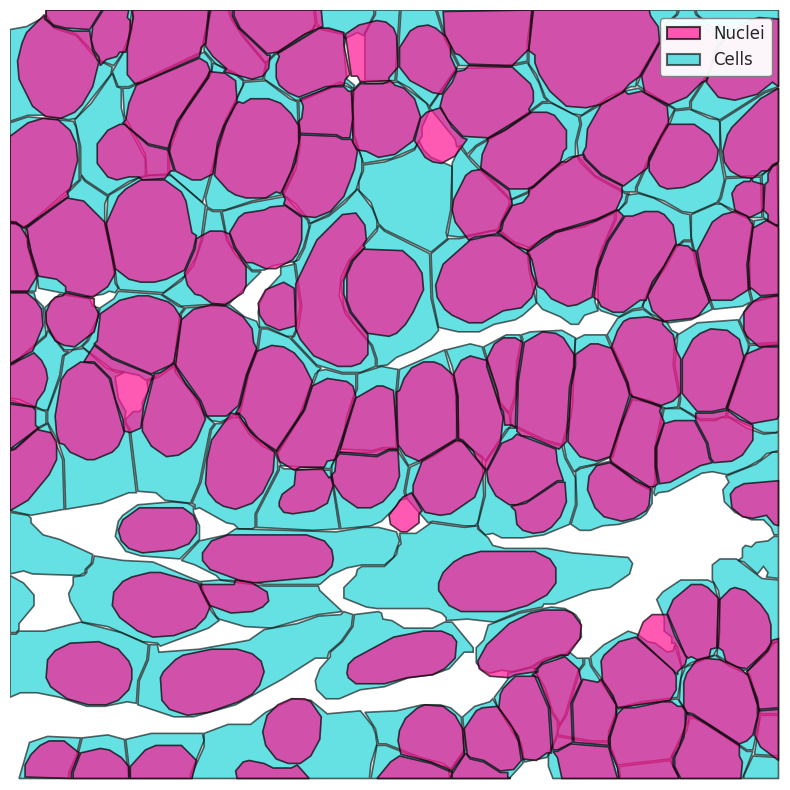

✅ Single panel figure created and saved!
   Modality: HE
   Background: white
   Nuclei: 110, Cells: 107
   Saved as: Fig_Segmentation_HE_White.pdf


In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import json
from shapely.geometry import shape
from matplotlib import rcParams
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# Critical settings for editable PDF
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans']
rcParams['pdf.fonttype'] = 42  # TrueType fonts for editability
rcParams['ps.fonttype'] = 42

def load_geojson(geojson_path):
    """Load GeoJSON detections"""
    try:
        with open(geojson_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Warning: {geojson_path} not found")
        return {'features': []}

def geojson_to_patches(geojson_data, color, alpha=1.0, linewidth=1.0, edge_color='white'):
    """Convert GeoJSON polygons to matplotlib patches"""
    patches = []
    
    if 'features' in geojson_data:
        features = geojson_data['features']
    elif 'geometries' in geojson_data:
        features = geojson_data['geometries']
    else:
        features = [geojson_data] if geojson_data else []
    
    for feature in features:
        try:
            if 'geometry' in feature:
                geom = shape(feature['geometry'])
            else:
                geom = shape(feature)
            
            if geom.geom_type == 'Polygon':
                coords = np.array(geom.exterior.coords)
                patch = mpatches.Polygon(coords, closed=True, 
                                        edgecolor=edge_color, facecolor=color, 
                                        alpha=alpha, linewidth=linewidth)
                patches.append(patch)
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = np.array(poly.exterior.coords)
                    patch = mpatches.Polygon(coords, closed=True,
                                            edgecolor=edge_color, facecolor=color,
                                            alpha=alpha, linewidth=linewidth)
                    patches.append(patch)
        except Exception as e:
            continue
    
    return patches

def create_single_panel_segmentation(modality='he', background='white', 
                                     save_path='Fig_Segmentation_Single_Panel.pdf'):
    """
    Create single panel figure showing segmentation overlays
    modality: 'he' or 'mif'
    background: 'white', 'black', or 'gray'
    """
    # Load image and segmentations based on modality
    if modality == 'he':
        img = np.array(Image.open('test_images/ovarian-he_chunk_69.png'))
        nuclei = load_geojson('results_dual_new/he_nuclei/nuclei_segmentation.geojson')
        cell = load_geojson('results_dual_new/he_cell/cell_segmentation.geojson')
    else:
        img = np.array(Image.open('test_images/ovarian-mif_chunk_69_combined.png'))
        nuclei = load_geojson('results_dual_new/mif_nuclei/nuclei_segmentation.geojson')
        cell = load_geojson('results_dual_new/mif_cell/cell_segmentation.geojson')
    
    # Colors
    nuclei_color = '#FF1493'  # Deep Pink
    cell_color = '#00CED1'    # Dark Turquoise
    
    # Background color
    bg_colors = {
        'white': '#FFFFFF',
        'black': '#000000',
        'gray': '#F5F5F5'
    }
    bg_color = bg_colors.get(background, '#FFFFFF')
    
    # Edge color (contrast with background)
    edge_color = 'black' if background == 'white' else 'white'
    
    # Create single panel figure
    fig, ax = plt.subplots(figsize=(8, 8), facecolor=bg_color)
    
    # Set up axes
    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(img.shape[0], 0)  # Inverted y-axis
    ax.set_facecolor(bg_color)
    
    # Add cell overlays
    cell_patches = geojson_to_patches(cell, cell_color, alpha=0.6, 
                                      linewidth=1.2, edge_color=edge_color)
    for patch in cell_patches:
        ax.add_patch(patch)
    
    # Add nuclei overlays
    nuclei_patches = geojson_to_patches(nuclei, nuclei_color, alpha=0.7, 
                                        linewidth=1.2, edge_color=edge_color)
    for patch in nuclei_patches:
        ax.add_patch(patch)
    
    ax.axis('off')
    ax.set_aspect('equal')
    
    # ===== Add Legend (no title) =====
    legend_elements = [
        mpatches.Patch(facecolor=nuclei_color, edgecolor=edge_color, 
                      alpha=0.7, label='Nuclei', linewidth=1.5),
        mpatches.Patch(facecolor=cell_color, edgecolor=edge_color, 
                      alpha=0.6, label='Cells', linewidth=1.5)
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', 
             frameon=True, fontsize=12, fancybox=True, 
             shadow=False, edgecolor='gray', framealpha=0.95)
    
    plt.tight_layout()
    
    # Save as editable PDF
    plt.savefig(save_path, format='pdf', bbox_inches='tight', 
                dpi=300, facecolor=bg_color)
    
    plt.show()
    
    print(f"✅ Single panel figure created and saved!")
    print(f"   Modality: {modality.upper()}")
    print(f"   Background: {background}")
    print(f"   Nuclei: {len(nuclei_patches)}, Cells: {len(cell_patches)}")
    print(f"   Saved as: {save_path}")
    
    return fig

# ========== CREATE AND SAVE FIGURE ==========

# H&E with white background
fig = create_single_panel_segmentation(
    modality='he', 
    background='white',
    save_path='Fig_Segmentation_HE_White.pdf'
)

# Uncomment for other options:

# # mIF with white background
# fig = create_single_panel_segmentation(
#     modality='mif', 
#     background='white',
#     save_path='Fig_Segmentation_mIF_White.pdf'
# )

# # H&E with black background
# fig = create_single_panel_segmentation(
#     modality='he', 
#     background='black',
#     save_path='Fig_Segmentation_HE_Black.pdf'
# )

# # Gray background
# fig = create_single_panel_segmentation(
#     modality='he', 
#     background='gray',
#     save_path='Fig_Segmentation_HE_Gray.pdf'
# )

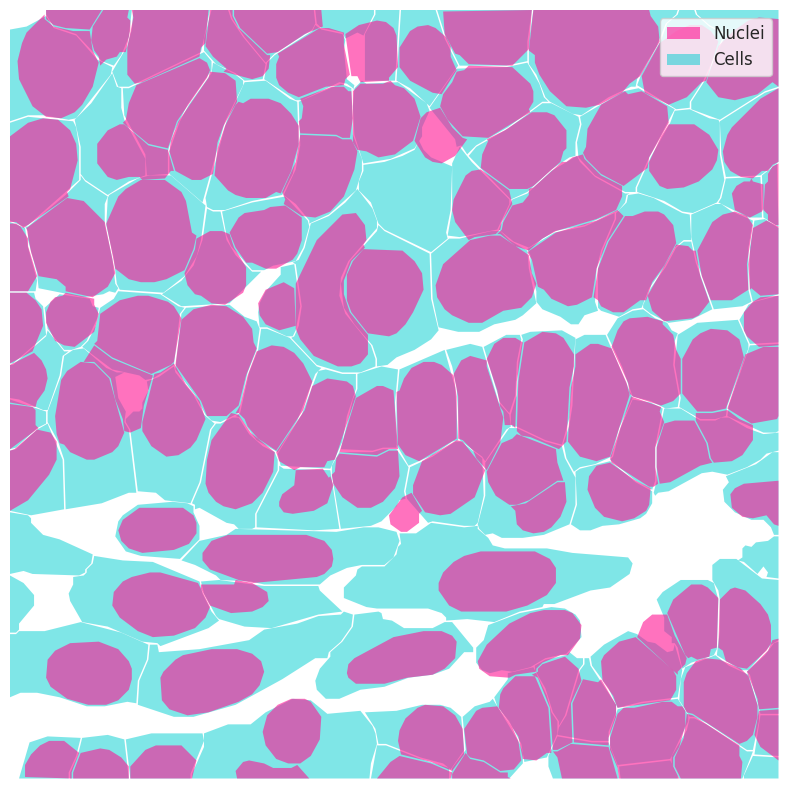

✅ Easy-edit version saved as: Fig_Segmentation_Easy_Edit.pdf
   In Illustrator: Use 'Select → Same → Fill Color' to select all nuclei/cells


In [32]:
def geojson_to_patches_solid(geojson_data, color, alpha=1.0):
    """Convert GeoJSON to solid filled patches (no stroke) for easier editing"""
    patches = []
    
    if 'features' in geojson_data:
        features = geojson_data['features']
    elif 'geometries' in geojson_data:
        features = geojson_data['geometries']
    else:
        features = [geojson_data] if geojson_data else []
    
    for feature in features:
        try:
            if 'geometry' in feature:
                geom = shape(feature['geometry'])
            else:
                geom = shape(feature)
            
            if geom.geom_type == 'Polygon':
                coords = np.array(geom.exterior.coords)
                # Solid fill, no edge
                patch = mpatches.Polygon(coords, closed=True, 
                                        edgecolor='none',  # No edge
                                        facecolor=color,   # Solid fill
                                        alpha=alpha, 
                                        linewidth=0)
                patches.append(patch)
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = np.array(poly.exterior.coords)
                    patch = mpatches.Polygon(coords, closed=True,
                                            edgecolor='none',
                                            facecolor=color,
                                            alpha=alpha,
                                            linewidth=0)
                    patches.append(patch)
        except Exception as e:
            continue
    
    return patches

def create_single_panel_easy_edit(modality='he', background='white', 
                                   save_path='Fig_Segmentation_Easy_Edit.pdf'):
    """Create figure optimized for easy editing in Illustrator"""
    
    if modality == 'he':
        img = np.array(Image.open('test_images/ovarian-he_chunk_69.png'))
        nuclei = load_geojson('results_dual_new/he_nuclei/nuclei_segmentation.geojson')
        cell = load_geojson('results_dual_new/he_cell/cell_segmentation.geojson')
    else:
        img = np.array(Image.open('test_images/ovarian-mif_chunk_69_combined.png'))
        nuclei = load_geojson('results_dual_new/mif_nuclei/nuclei_segmentation.geojson')
        cell = load_geojson('results_dual_new/mif_cell/cell_segmentation.geojson')
    
    # Distinct solid colors
    nuclei_color = '#FF1493'  # Deep Pink
    cell_color = '#00CED1'    # Dark Turquoise
    
    bg_colors = {'white': '#FFFFFF', 'black': '#000000', 'gray': '#F5F5F5'}
    bg_color = bg_colors.get(background, '#FFFFFF')
    
    fig, ax = plt.subplots(figsize=(8, 8), facecolor=bg_color)
    
    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(img.shape[0], 0)
    ax.set_facecolor(bg_color)
    
    # Add cell overlays (solid fill, no edge)
    cell_patches = geojson_to_patches_solid(cell, cell_color, alpha=0.5)
    for patch in cell_patches:
        ax.add_patch(patch)
    
    # Add nuclei overlays (solid fill, no edge)
    nuclei_patches = geojson_to_patches_solid(nuclei, nuclei_color, alpha=0.6)
    for patch in nuclei_patches:
        ax.add_patch(patch)
    
    ax.axis('off')
    ax.set_aspect('equal')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=nuclei_color, edgecolor='none', 
                      alpha=0.6, label='Nuclei'),
        mpatches.Patch(facecolor=cell_color, edgecolor='none', 
                      alpha=0.5, label='Cells')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', 
             frameon=True, fontsize=12, fancybox=True)
    
    plt.tight_layout()
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"✅ Easy-edit version saved as: {save_path}")
    print(f"   In Illustrator: Use 'Select → Same → Fill Color' to select all nuclei/cells")
    
    return fig

# Generate new version
fig = create_single_panel_easy_edit(
    modality='he',
    background='white',
    save_path='Fig_Segmentation_Easy_Edit.pdf'
)